# Fashion MNIST classification (cont.)



This notebook is built upon the [TensorFlow image classification tutorial](https://www.tensorflow.org/tutorials/keras/classification), which trains a neural network model to classify Fashion MNIST dataset. It's okay if you don't understand all the details of the implementation; this is a fast-paced overview of a complete TensorFlow program with the details explained as you go. We use [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(42)
tf.random.set_seed(42)
tf.compat.v1.set_random_seed(42)
tf.experimental.numpy.random.seed(42)
print(tf.__version__)

2.12.0


## Preprocess the data as in the starter code

### Import the Fashion MNIST dataset

You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

We will split a validation set from the training set later.

### Scale and flatten the images

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. Moreover, flatten the 28x28 NumPy arrays into 784 dimension feature vectors. 

It's important that the *training set* and the *testing set* be preprocessed in the same way.

In [3]:
train_images = (train_images / 255.0).reshape(train_images.shape[0], -1)
test_images = (test_images / 255.0).reshape(test_images.shape[0], -1)
train_images.shape

(60000, 784)

The *labels* are an array of integers, ranging from 0 to 9. Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Split train/validation/test sets

Same as the starter code, take the first 10k data in the *training set* as the training data, and the last 2k data in the *training set* as the validation data. The test data is all the 10k data in the *testing set*.

In [5]:
# sample 5k training, 1k validation, making sure the label is balanced
label_idxs = [np.where(train_labels == i)[0] for i in range(10)]
Xtrain, Ytrain, Xval, Yval = \
    np.concatenate([train_images[label_idxs[i][:1000]] for i in range(10)]), \
    np.concatenate([train_labels[label_idxs[i][:1000]] for i in range(10)]), \
    np.concatenate([train_images[label_idxs[i][-200:]] for i in range(10)]), \
    np.concatenate([train_labels[label_idxs[i][-200:]] for i in range(10)])

# shuffle data before training
idx_order = np.random.permutation(Xtrain.shape[0])
Xtrain = Xtrain[idx_order]
Ytrain = Ytrain[idx_order]

Xtest, Ytest = test_images, test_labels

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the training data and display the class name below each image.

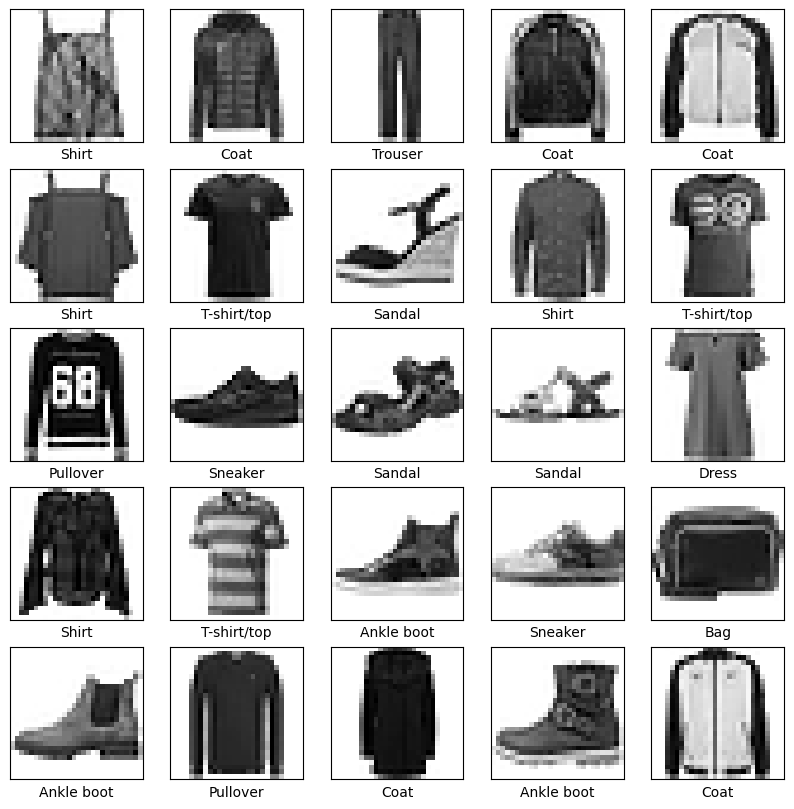

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(Xtrain[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(class_names[Ytrain[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up two linear layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [7]:
base_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

Metal device set to: Apple M1 Pro


The network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 1000 nodes (or neurons). The second layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [8]:
base_model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Setup early-stopping

Define the early-stopping module as a callback module to stop the training process.

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "for at least 3 epochs"
        patience=3,
        verbose=1,
    )
]

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `Xtrain` and `Ytrain` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `Xtest` array.
4. Verify that the predictions match the labels from the `Ytest` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data. It automatically processes the forward pass and the backward pass.

---



In [10]:
base_model.fit(
    Xtrain, Ytrain, 
    batch_size=5, epochs=50, 
    callbacks=callbacks,
    validation_data=(Xval, Yval))

Epoch 1/50


2024-03-12 22:10:19.826497: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2000/2000 [==============================] - 10s 5ms/step - loss: 0.7987 - accuracy: 0.7308 - val_loss: 0.5827 - val_accuracy: 0.7885
Epoch 2/50
2000/2000 [==============================] - 9s 5ms/step - loss: 0.5463 - accuracy: 0.8075 - val_loss: 0.4907 - val_accuracy: 0.8230
Epoch 3/50
2000/2000 [==============================] - 10s 5ms/step - loss: 0.4925 - accuracy: 0.8251 - val_loss: 0.5079 - val_accuracy: 0.8070
Epoch 4/50
2000/2000 [==============================] - 9s 5ms/step - loss: 0.4523 - accuracy: 0.8404 - val_loss: 0.4456 - val_accuracy: 0.8385
Epoch 5/50
2000/2000 [==============================] - 9s 5ms/step - loss: 0.4255 - accuracy: 0.8509 - val_loss: 0.4377 - val_accuracy: 0.8430
Epoch 6/50
2000/2000 [==============================] - 9s 5ms/step - loss: 0.4064 - accuracy: 0.8545 - val_loss: 0.4285 - val_accuracy: 0.8405
Epoch 7/50
2000/2000 [==============================] - 9s 5ms/step - loss: 0.3891 - accuracy: 0.8649 - val_loss: 0.4362 - val_accuracy: 0.8405
E

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [11]:
test_loss, test_acc = base_model.evaluate(Xtest,  Ytest, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.4864 - accuracy: 0.8299 - 1s/epoch - 4ms/step

Test accuracy: 0.8299000263214111


**The accuracy that we obtain here is similar (+/- 1.5) to the accuracy from your own Python code for a batch size of 5. You can check your results to verify this.**

## Problem 3.3: The effect of early-stopping

We provided built-in early-stopping in the starter code, but did not explore the effect that it has on training. In this question, we will explore the effect of early-stopping. To do this, we evaluate the training, validation and test accuracy for each training epoch. We then plot the training, validation and test accuracy throughout the training process to see how early-stopping works.

To make sure the training process is the same as the previous `base_model`, we set the same random seed for training. Connecting all the training-evaluation modules together, we train 30 epochs on a batch size of 5 without early-stopping:

In [12]:
# set the same random seed to make sure the model initialized at the same weights.
tf.random.set_seed(42)
tf.compat.v1.set_random_seed(42)
tf.experimental.numpy.random.seed(42)
# build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
test_acc = []
# setup a callback for evaluate the test set
class TestCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        res_test = self.model.evaluate(Xtest, Ytest, verbose = 0)
        test_acc.append(res_test[1])
my_test_callback = TestCallback()
# compile the model
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# train the model without callbacks
train_test_history = model.fit(
    Xtrain, Ytrain, 
    batch_size=5, epochs=30,
    callbacks=[my_test_callback],
    validation_data=(Xval, Yval))

Epoch 1/30
2000/2000 [==============================] - 11s 5ms/step - loss: 0.7898 - accuracy: 0.7339 - val_loss: 0.5727 - val_accuracy: 0.8000
Epoch 2/30
2000/2000 [==============================] - 11s 5ms/step - loss: 0.5443 - accuracy: 0.8088 - val_loss: 0.4913 - val_accuracy: 0.8215
Epoch 3/30
2000/2000 [==============================] - 11s 5ms/step - loss: 0.4918 - accuracy: 0.8262 - val_loss: 0.5060 - val_accuracy: 0.8125
Epoch 4/30
2000/2000 [==============================] - 11s 5ms/step - loss: 0.4531 - accuracy: 0.8419 - val_loss: 0.4427 - val_accuracy: 0.8335
Epoch 5/30
2000/2000 [==============================] - 11s 5ms/step - loss: 0.4257 - accuracy: 0.8514 - val_loss: 0.4392 - val_accuracy: 0.8360
Epoch 6/30
2000/2000 [==============================] - 11s 5ms/step - loss: 0.4079 - accuracy: 0.8545 - val_loss: 0.4259 - val_accuracy: 0.8445
Epoch 7/30
2000/2000 [==============================] - 11s 5ms/step - loss: 0.3891 - accuracy: 0.8651 - val_loss: 0.4329 - val_ac

### Visualize the accuracy without early-stopping

Run the provided code to plot the training accuracy *vs.* the number of epochs. On the same graph, we plot the test accuracy *vs.* the number of epochs. To do this, we retrieve loss and accuracy information in `train_test_history.history`. We also use `plt.scatter` to mark the point on the test accuracy curve where we early-stopped previously.

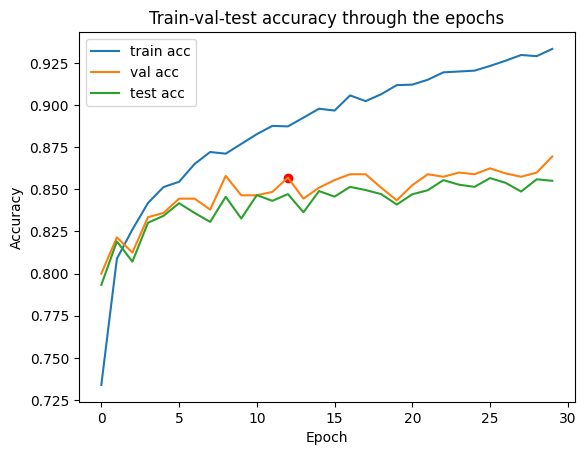

In [13]:
x = np.arange(len(train_test_history.history['accuracy']))
train_acc = train_test_history.history['accuracy']
val_acc = train_test_history.history['val_accuracy']

plt.title("Train-val-test accuracy through the epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(x, train_acc, label="train acc")
plt.plot(x, val_acc, label="val acc")
plt.plot(x, test_acc, label="test acc")
plt.scatter([x[12]], [val_acc[12]], color="red")
plt.legend()
plt.show()

Based on the curve, answer the following questions:

*   What is the trend of training and test accuracy after the early-stopped point?
*   Based on the plot, what do you think could go wrong if the patience parameter for early-stopping is too small?



## Problem 3.4: SGD with momentum



We mentioned in the lecture that adding a “momentum” term, which encourages model to continue along previous gradient direction, helps the network to converge. Concretely, with an initial velocity $v=0$, we update the gradient by

$v ← \alpha v + \nabla F(w)$

$w ← w - \eta v$

where $\eta$ is the learning rate and $\alpha$ is the factor describing how much weight we put on the previous gradients. $\alpha=0$ is equivalent to gradient update without momentum. 

We provide the `sgd_with_momentum` function with argument $\alpha$ below. In this question, we will explore the  momentum factor $\alpha$ effects training loss and test accuracy.

In [14]:
def sgd_with_momentum(alpha):
  # set the same random seed to make sure the model initialized at the same weights.
  tf.random.set_seed(42)
  tf.compat.v1.set_random_seed(42)
  tf.experimental.numpy.random.seed(42)
  # build the model
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  # compile the model
  model.compile(optimizer=tf.keras.optimizers.SGD(momentum=alpha),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  # train the model without early-stopping
  history = model.fit(
      Xtrain, Ytrain, 
      batch_size=5, epochs=30)
  # evaluate the model
  test_loss, test_acc = model.evaluate(Xtest,  Ytest, verbose=2)
  # return training loss and test accuracy
  return history.history['loss']

### Visualize training loss and test accuracy with different momentum factor $\alpha$

We will explore how different momentum factor $\alpha$ effects training loss and test accuracy. Call the `sgd_with_momentum` function with $\alpha$ = 0.1, 0.3, 0.5, 0.7, 0.9. Store the training loss and test accuracy from the return of the function.

In [15]:
train_losses = []

for alpha in np.arange(0.1, 1, 0.2):
  train_loss = sgd_with_momentum(alpha)
  train_losses.append(train_loss)

Epoch 1/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.7724 - accuracy: 0.7373
Epoch 2/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.5378 - accuracy: 0.8137
Epoch 3/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4829 - accuracy: 0.8285
Epoch 4/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4433 - accuracy: 0.8435
Epoch 5/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4164 - accuracy: 0.8542
Epoch 6/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3978 - accuracy: 0.8585
Epoch 7/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3801 - accuracy: 0.8670
Epoch 8/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3608 - accuracy: 0.8729
Epoch 9/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3489 - accuracy: 0.8752
Epoch 10/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.335

Epoch 1/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.7410 - accuracy: 0.7481
Epoch 2/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.5212 - accuracy: 0.8175
Epoch 3/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4699 - accuracy: 0.8339
Epoch 4/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4288 - accuracy: 0.8502
Epoch 5/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4026 - accuracy: 0.8578
Epoch 6/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3842 - accuracy: 0.8613
Epoch 7/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3642 - accuracy: 0.8706
Epoch 8/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3461 - accuracy: 0.8780
Epoch 9/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3322 - accuracy: 0.8803
Epoch 10/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.318

Epoch 1/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.7197 - accuracy: 0.7527
Epoch 2/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.5103 - accuracy: 0.8190
Epoch 3/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4554 - accuracy: 0.8366
Epoch 4/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4130 - accuracy: 0.8527
Epoch 5/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3869 - accuracy: 0.8609
Epoch 6/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3677 - accuracy: 0.8669
Epoch 7/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3476 - accuracy: 0.8723
Epoch 8/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3272 - accuracy: 0.8836
Epoch 9/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3140 - accuracy: 0.8856
Epoch 10/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.299

Epoch 1/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.6882 - accuracy: 0.7577
Epoch 2/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4975 - accuracy: 0.8228
Epoch 3/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4371 - accuracy: 0.8417
Epoch 4/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3975 - accuracy: 0.8578
Epoch 5/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3717 - accuracy: 0.8629
Epoch 6/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3561 - accuracy: 0.8689
Epoch 7/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3350 - accuracy: 0.8776
Epoch 8/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3166 - accuracy: 0.8840
Epoch 9/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.2993 - accuracy: 0.8908
Epoch 10/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.286

Epoch 1/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.7459 - accuracy: 0.7305
Epoch 2/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.5936 - accuracy: 0.7867
Epoch 3/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.5154 - accuracy: 0.8129
Epoch 4/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4757 - accuracy: 0.8260
Epoch 5/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4410 - accuracy: 0.8379
Epoch 6/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4228 - accuracy: 0.8438
Epoch 7/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4169 - accuracy: 0.8510
Epoch 8/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3922 - accuracy: 0.8551
Epoch 9/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3894 - accuracy: 0.8566
Epoch 10/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.374

We visualize the training loss. Plot 5 curve of different $\alpha$ on the same graph. Each curve has epoch number as the $x$-axis and the training loss as the $y$-axis.  Based on this, what is a suitable value of $\alpha$? Therefore, how should training ideally rely on previous gradients for better convergence?

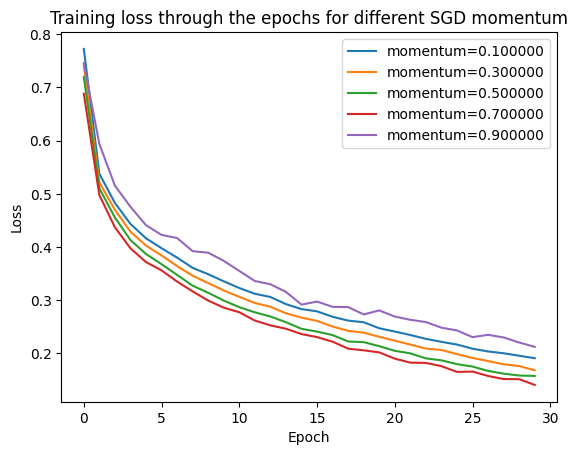

In [16]:
x = np.arange(len(train_losses[0]))

plt.title("Training loss through the epochs for different SGD momentum")
plt.xlabel("Epoch")
plt.ylabel("Loss")
for i, alpha in enumerate(np.arange(0.1, 1, 0.2)):
  plt.plot(x, train_losses[i], label="momentum=%f" % alpha)
plt.legend()
plt.show()

## [Bonus] Problem 3.5: Out-of-domain generalization

A major research direction at present is to ensure that our ML models not only do well on test data drawn from the same distribution as training data, but also do well when they get data from distributions different from the original distribution. This is known as Out-of-Distribution (OOD) generalization. In the Fashion MNIST dataset, the training and test set are drawn from the same distribution. Let's explore how our models do on test data coming from a slightly different distribution.


### Create OOD test set by translation

Take a look at the original test set of Fashion MNIST.

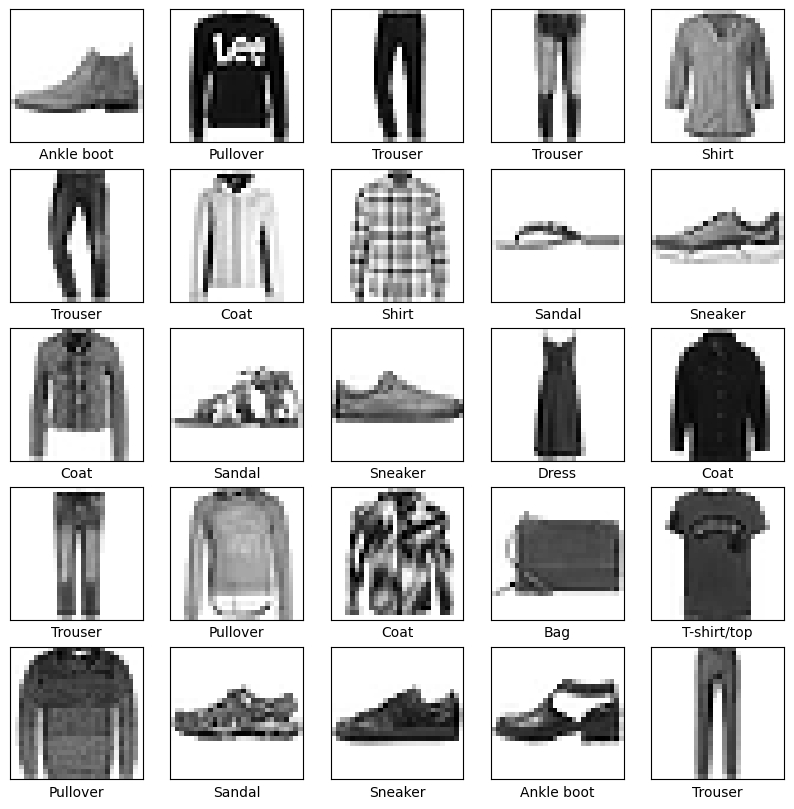

In [17]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(Xtest[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(class_names[Ytest[i]])
plt.show()

We move up the images of the test set by 4 pixels, and create a new translated test set from that. You will notice that to a human eye, the new test set is not any more difficult than the original test set.

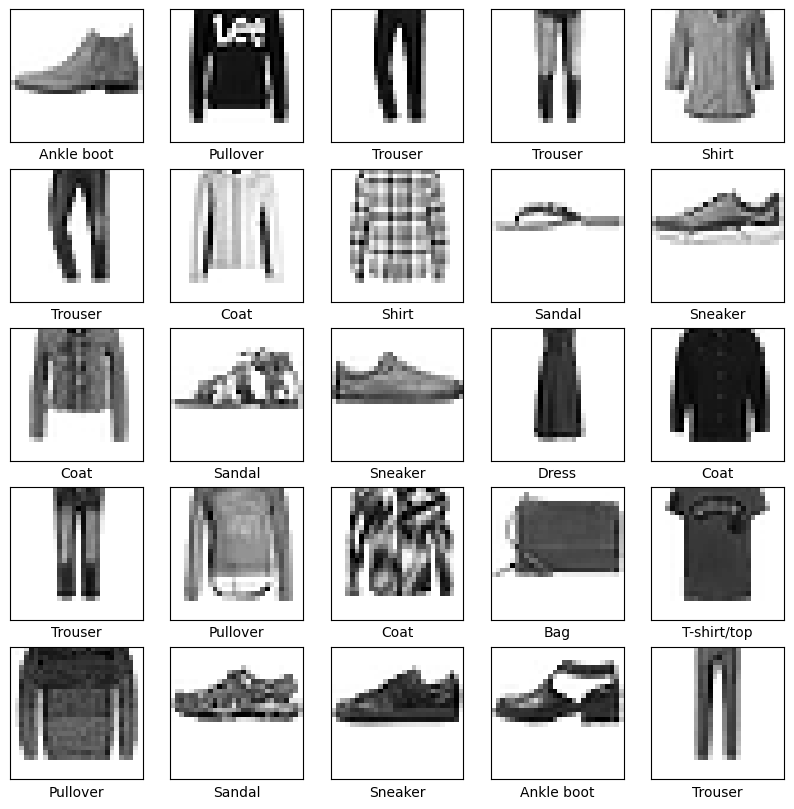

In [18]:
# lift the image by 4 pixels
translate_x = 4
translate_y = 0

Xtest_t4 = np.pad(Xtest.reshape(-1, 28, 28)[:, translate_x:, translate_y:], 
                  ((0, 0), (0, translate_x), (0, translate_y))).reshape(-1, 784)


# visualize the translation
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(Xtest_t4[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(class_names[Ytest[i]])
plt.show()

*But can the MLP model still identify it well?* Check the test accuracy on the base model.

In [19]:
test_loss, test_acc = base_model.evaluate(Xtest_t4,  Ytest, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 1.9484 - accuracy: 0.4520 - 1s/epoch - 4ms/step

Test accuracy: 0.4520000219345093


### Convolutional Neural Network

What if we try a different model architecture? For example, in class we saw that convolutional neural networks are good at dealing with image translation. We replace the first linear layer with a convolutional layer of 64 kernels with size $7\times7$, followed by max-pooling. This can be done with just one or two lines of code in TensorFlow. We train the 2-layer CNN on the original training data and test it on both the original and the translated test sets.

In [20]:
# set the same random seed.
tf.random.set_seed(42)
tf.compat.v1.set_random_seed(42)
tf.experimental.numpy.random.seed(42)
# replace the linear layer with a conv layer of 64 7*7 kernels, followed by maxpooling.
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
    tf.keras.layers.Conv2D(64, (7, 7), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])
# compile the model
cnn_model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# train the model with early-stopping
cnn_model.fit(
    Xtrain, Ytrain, 
    batch_size=5, epochs=50,
    callbacks=callbacks,
    validation_data=(Xval, Yval))
# evaluate on the original test set
test_loss, test_acc = cnn_model.evaluate(Xtest,  Ytest, verbose=2)
print('In-domain test accuracy:', test_acc)
# evaluate on the translated test set
test_loss, test_acc = cnn_model.evaluate(Xtest_t4,  Ytest, verbose=2)
print('Out-of-domain test accuracy:', test_acc)

Epoch 1/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.8046 - accuracy: 0.7158 - val_loss: 0.5519 - val_accuracy: 0.7980
Epoch 2/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.5191 - accuracy: 0.8178 - val_loss: 0.4624 - val_accuracy: 0.8375
Epoch 3/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.4556 - accuracy: 0.8402 - val_loss: 0.4754 - val_accuracy: 0.8135
Epoch 4/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.4156 - accuracy: 0.8587 - val_loss: 0.3907 - val_accuracy: 0.8535
Epoch 5/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.3865 - accuracy: 0.8637 - val_loss: 0.3928 - val_accuracy: 0.8590
Epoch 6/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.3630 - accuracy: 0.8702 - val_loss: 0.3718 - val_accuracy: 0.8645
Epoch 7/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.3465 - accuracy: 0.8797 - val_loss: 0.3859 - val_ac

Show the CNN model has fewer parameters (compute by hand, you can use 
`cnn_model.trainable_variables` to verify your calculation) than the 2-layer 
MLP. What is the in-domain test accuracy and the translated test accuracy?




### Make the CNN Deeper

Going one step further, we can make the CNN deeper by adding one more convolutional layer between the two existing layers. 

In [21]:
# set the same random seed.
tf.random.set_seed(42)
tf.compat.v1.set_random_seed(42)
tf.experimental.numpy.random.seed(42)
# add one more conv layer of 128 2*2 kernels in between, followed by maxpooling.
cnn_model_deeper = tf.keras.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
    tf.keras.layers.Conv2D(64, (7, 7), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])
# compile the model
cnn_model_deeper.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# train the model with early-stopping
cnn_model_deeper.fit(
    Xtrain, Ytrain, 
    batch_size=5, epochs=50,
    callbacks=callbacks,
    validation_data=(Xval, Yval))
# evaluate on the original test set
test_loss, test_acc = cnn_model_deeper.evaluate(Xtest,  Ytest, verbose=2)
print('In-domain test accuracy:', test_acc)
# evaluate on the translated test set
test_loss, test_acc = cnn_model_deeper.evaluate(Xtest_t4,  Ytest, verbose=2)
print('Out-of-domain test accuracy:', test_acc)

Epoch 1/50
2000/2000 [==============================] - 13s 6ms/step - loss: 0.9276 - accuracy: 0.6700 - val_loss: 0.6006 - val_accuracy: 0.7750
Epoch 2/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.5602 - accuracy: 0.7988 - val_loss: 0.4943 - val_accuracy: 0.8180
Epoch 3/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.4803 - accuracy: 0.8266 - val_loss: 0.5108 - val_accuracy: 0.8015
Epoch 4/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.4353 - accuracy: 0.8456 - val_loss: 0.4169 - val_accuracy: 0.8455
Epoch 5/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.4043 - accuracy: 0.8557 - val_loss: 0.4061 - val_accuracy: 0.8560
Epoch 6/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.3806 - accuracy: 0.8639 - val_loss: 0.3910 - val_accuracy: 0.8600
Epoch 7/50
2000/2000 [==============================] - 12s 6ms/step - loss: 0.3631 - accuracy: 0.8701 - val_loss: 0.4070 - val_ac

Show the deeper 3-layer CNN model has fewer parameters (compute by hand, you can use `cnn_model.trainable_variables` to verify your calculation) than the 2-layer CNN model. What is the in-domain and the translated test accuracy of the deeper CNN model? Provide some intuition on why it is better than the 2-layer CNN on the translated set.

### Create OOD test set by rotation



Next, we create 3 more OOD test sets by rotation. We rotate the images in the original test set by 90, 180 and 270 degrees.

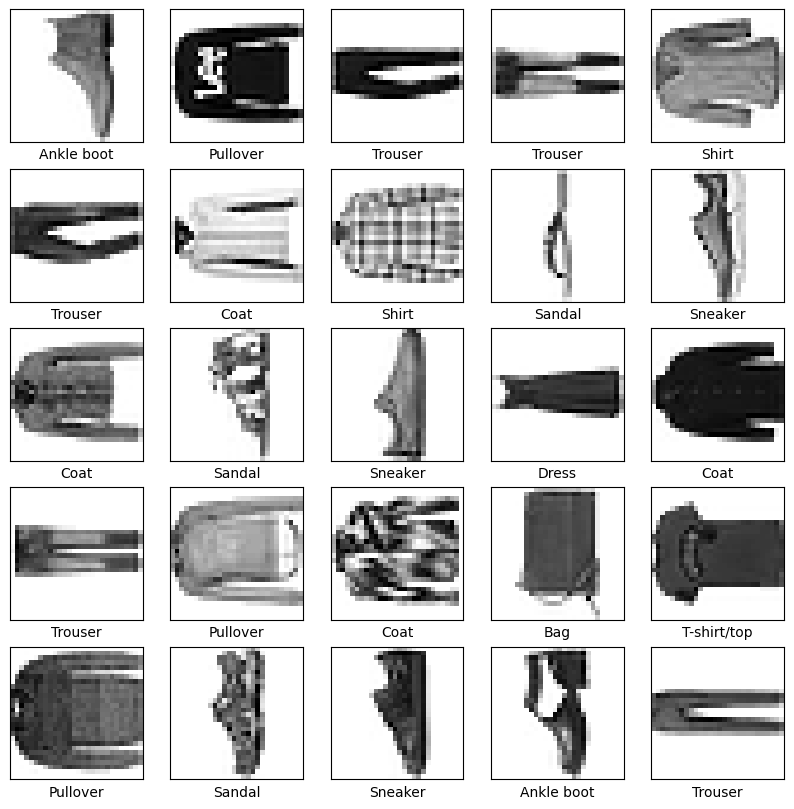

In [22]:
# rotate 90 degrees counter-clockwise 
Xtest_r90 = np.rot90(Xtest.reshape(-1, 28, 28), k=1, axes=(1, 2)).reshape(-1, 784)

# rotate 180 degrees counter-clockwise 
Xtest_r180 = np.rot90(Xtest.reshape(-1, 28, 28), k=2, axes=(1, 2)).reshape(-1, 784)

# rotate 270 degrees counter-clockwise 
Xtest_r270 = np.rot90(Xtest.reshape(-1, 28, 28), k=3, axes=(1, 2)).reshape(-1, 784)

# visualize the 90 degrees rotation
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(Xtest_r90[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(class_names[Ytest[i]])
plt.show()

Provide the test accuracy of the base model, the CNN model  and the deeper CNN model on the three rotation test sets. Are the CNN and the deeper CNN still doing well?

In [23]:
print("Rotation 90 degrees:")

test_loss, test_acc = base_model.evaluate(Xtest_r90,  Ytest, verbose=2)
print('Base model accuracy:', test_acc)
test_loss, test_acc = cnn_model.evaluate(Xtest_r90,  Ytest, verbose=2)
print('CNN model accuracy:', test_acc)
test_loss, test_acc = cnn_model_deeper.evaluate(Xtest_r90,  Ytest, verbose=2)
print('Deeper CNN model accuracy:', test_acc)

print("Rotation 180 degrees:")

test_loss, test_acc = base_model.evaluate(Xtest_r180,  Ytest, verbose=2)
print('Base model accuracy:', test_acc)
test_loss, test_acc = cnn_model.evaluate(Xtest_r180,  Ytest, verbose=2)
print('CNN model accuracy:', test_acc)
test_loss, test_acc = cnn_model_deeper.evaluate(Xtest_r270,  Ytest, verbose=2)
print('Deeper CNN model accuracy:', test_acc)

print("Rotation 270 degrees:")

test_loss, test_acc = base_model.evaluate(Xtest_r270,  Ytest, verbose=2)
print('Base model accuracy:', test_acc)
test_loss, test_acc = cnn_model.evaluate(Xtest_r270,  Ytest, verbose=2)
print('CNN model accuracy:', test_acc)
test_loss, test_acc = cnn_model_deeper.evaluate(Xtest_r270,  Ytest, verbose=2)
print('Deeper CNN model accuracy:', test_acc)

Rotation 90 degrees:
313/313 - 1s - loss: 6.8540 - accuracy: 0.0187 - 1s/epoch - 4ms/step
Base model accuracy: 0.018700001761317253
313/313 - 1s - loss: 7.4860 - accuracy: 0.0557 - 1s/epoch - 4ms/step
CNN model accuracy: 0.05570000410079956
313/313 - 1s - loss: 8.0601 - accuracy: 0.0565 - 1s/epoch - 4ms/step
Deeper CNN model accuracy: 0.05650000274181366
Rotation 180 degrees:
313/313 - 1s - loss: 5.2465 - accuracy: 0.1828 - 1s/epoch - 4ms/step
Base model accuracy: 0.18280000984668732
313/313 - 1s - loss: 5.6980 - accuracy: 0.2174 - 1s/epoch - 4ms/step
CNN model accuracy: 0.21740001440048218
313/313 - 1s - loss: 10.9566 - accuracy: 0.0590 - 1s/epoch - 4ms/step
Deeper CNN model accuracy: 0.05900000408291817
Rotation 270 degrees:
313/313 - 1s - loss: 8.5701 - accuracy: 0.0506 - 1s/epoch - 4ms/step
Base model accuracy: 0.05060000345110893
313/313 - 1s - loss: 9.8792 - accuracy: 0.0403 - 1s/epoch - 4ms/step
CNN model accuracy: 0.040300000458955765
313/313 - 1s - loss: 10.9566 - accuracy: 0.